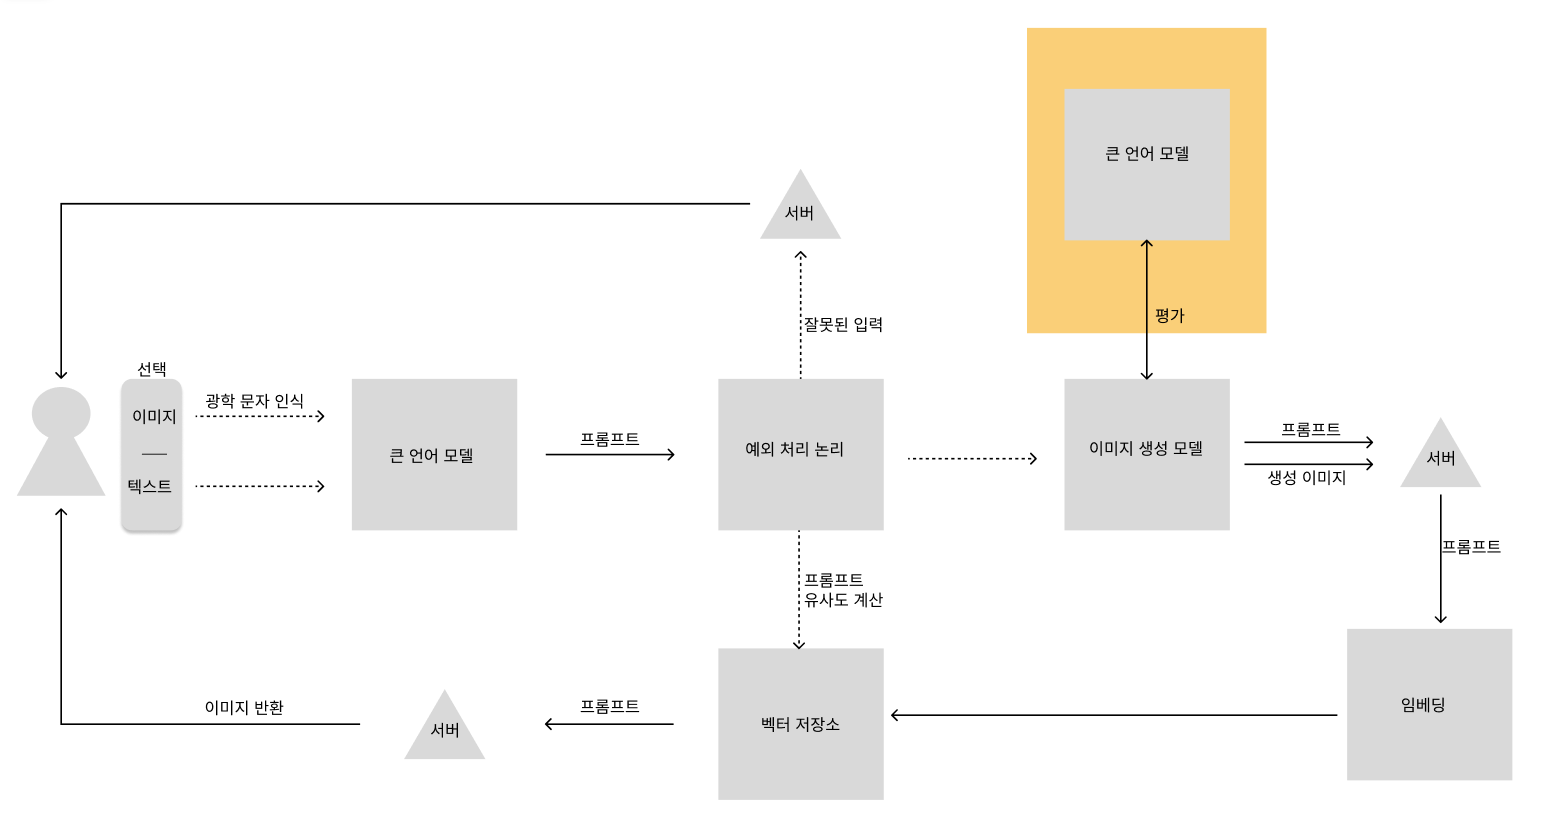

# Load Library

In [1]:
import sys
import os
import re
import json
import numpy as np
import pandas as pd

import subprocess
from typing import Union, List
from PIL import Image
import pytesseract

from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

import torch
print("PyTorch 버전:", torch.__version__)
print("CUDA 사용 가능:", torch.cuda.is_available())
print("CUDA 버전:", torch.version.cuda)
print("GPU 이름:", torch.cuda.get_device_name(0))


PyTorch 버전: 2.6.0+cu126
CUDA 사용 가능: True
CUDA 버전: 12.6
GPU 이름: Tesla T4


# Sample data

In [2]:
data = pd.read_csv('./temple_recipe.csv')
data2 = data[['name', 'steps']]
data2

name                                              steps
0      당근 양념겉절이  ['1. 겉절이채소는 양상추, 치커리, 샐러드채소를 준비하여 물에 씻어 먹기 좋은 ...
1         연근백김치  ['1. 연근은 껍질을 벗기고 씻어서 얇게 썬다.\n소금을 뿌려 10분 정도 절인다...
2   늙은 호박 양념겉절이  ['1. 겉절이채소는 다듬어 먹기 좋게 썬다.', '2. 버섯은 양송이버섯, 느타리...
3         수삼물김치  ['1. 배추는 깨끗이 씻어 3 × 3cm 크기로 자른다.', '2. 무는 깨끗이 ...
4          고추김치  ['1. 무는 깨끗이 씻어 껍질을 벗기고 5 × 0.3cm 크기로 채 썬다.', '...
..          ...                                                ...
72      얼갈이오이김치  ['1. 1. 볼에 보리가루, 물, 굵은 소금, 간장을 넣고 잘 섞어준 뒤 냄비에서...
73        연근물김치  ['1. 1. 연근은 껍질을 벗겨 0.5cm 두께로 썰어 준다.', '2. 2. 배...
74        열무겉절이  ['1. 1. 열무는 손질하여 5~6cm 길이로 잘라 씻은 뒤, 소금을 넣고 고루 ...
75         열무김치  ['1. 1. 열무는 손질하여 5~6cm 길이로 잘라 씻은 뒤, 소금 2큰술을 넣고...
76     생두부 양념김치  ['1. 1. 두부는 흐르는 물에 씻은 뒤 5×3×1cm 크기로 자른다.', '2....

[77 rows x 2 columns]

In [30]:
i+=1
data2['steps'].iloc[i]

"['1. 청경채는 깨끗이 씻어 반으로 잘라 소금물에 10분 정도 절인다.', '2. 무의 1/2분량은 2cm 길이로 잘라 위로 칼집을 넣어 소금을 뿌려 1시간 정도 절인다.', '3. 나머지 무는 5×0.3cm 크기로 채 썬다.', '4. 미나리는 뿌리 쪽을 잡고 밑동을 잘라준다. 큰 그릇에 물을 받아 미나리를 넣고 식초를 2큰술 정도 넣어 잘 섞어준 뒤 10분 정도 담가 거머리를 제거한다. 흐르는 물에 2~3번 정도 씻어 4cm 길이로 자른다.', '5. 청·홍고추도 깨끗이 씻어 씨를 제거하고 2×0.3cm 크기로 채 썬다.', '6. 채 썬 무, 미나리, 청·홍고추를 고루 섞어 소금으로 간한다.', '7. 살짝 절인 청경채는 한번 헹구어 채반에 건져 물기를 빼고 켜켜이 양념소를 넣는다.', '8. 충분히 절인 무도 버무려 놓은 양념소를 칼집사이에 꼭꼭 채워 넣어 청경채와 함께 김치통에 차곡차곡 담는다.', '9. 채수 1컵에 고춧가루를 넣고 고운체에 한 번 거른 뒤 소금으로 간을 맞춰 남은 채수 2컵과 섞어 김치통에 붓고 실온에서 익혀 냉장 보관한다.']"

# Prompt Generation

In [ ]:
# 버전 1

from typing import List
from PIL import Image
import pytesseract
import re
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# 1. Ollama 모델 초기화
llm = Ollama(model="gemma3:12b")

# 2. OCR 텍스트 추출 함수

def extract_text_from_image(image: Image.Image) -> str:
    ocr_text = pytesseract.image_to_string(image, lang="kor+eng")
    if not ocr_text.strip():
        raise ValueError("이미지에서 텍스트를 추출할 수 없습니다.")
    return ocr_text.strip()

# 3. 요리 설명 → 단계 분리 프롬프트
parse_prompt = PromptTemplate.from_template(
    """
다음 요리 설명을 조리 단계별로 1, 2, 3, ... 형식으로 나누어 주세요.  
각 단계는 **간결하고 구체적으로** 작성하되, 다음 지침을 반드시 따르세요:

1. 각 단계는 **주어 + 조리 동작 + 재료 + 도구**가 포함된 완전한 문장으로 표현합니다.  
2. 만약 주어나 재료가 생략되었거나 모호하다면, **이전 단계의 흐름과 재료를 참조하여 추론한 내용을 명시적으로 작성**하세요.  
    - 실제 텍스트에 등장하지 않은 **불필요한 조리 동작(blanching, boiling 등)은 추론하지 마세요.**
    - 이전 단계에서 이미 수행한 동작(예: 같은 재료를 반복 써는 것 등)은 **중복하지 마세요.**
3. 각 단계는 가능한 한 **시각적으로 그릴 수 있을 정도로 구체적인 동작 중심**으로 설명합니다.

요리 설명:
'''{content}'''

단계:
"""
)

# 4. 단계 분리 함수
def parse_steps_with_llm(raw_input: str) -> List[str]:
    chain = LLMChain(llm=llm, prompt=parse_prompt)
    parsed = chain.run(content=raw_input).strip()

    steps = re.findall(r'\d+\.\s+(.*?)(?=\d+\.\s+|$)', parsed, re.DOTALL)
    if steps:
        return [s.strip() for s in steps]

    rough = re.split(r'\.\s*\n|\.\s|[\n]', parsed)
    return [s.strip() for s in rough if s.strip()]

# 5. 시각 근사 재료 사전
VISUAL_SUBSTITUTE_DICT = {
    "쪽파": "scallions",
    "청갓": "mustard greens",
    "고들빼기": "wild lettuce",
    "까나리액젓": "fish sauce",
    "물엿": "starch syrup",
    "찹쌀풀": "rice paste",
    "고운 고춧가루": "chili flakes",
    "마늘": "garlic",
    "통깨": "sesame seeds",
    "당근": "carrots"
}

# 6. 프롬프트 템플릿 (최적화 적용)
image_prompt_template = PromptTemplate.from_template(
    """
[입력: 조리 단계 (한국어)]
{content}

[Stable Diffusion Prompt 생성 규칙]

1. 문장을 자연스럽고 간결한 영어로 번역합니다.
2. 재료명은 시각적으로 표현 가능한 영어 단어로 자동 치환합니다. (예: 쪽파 → scallions)
3. **조리 동작 + 도구 + 핵심 재료**를 문장 앞부분에 배치하여 CLIP 모델이 시각적으로 강조할 수 있도록 합니다.
4. 도구는 가능한 구체적으로 표현합니다. (예: 칼 → kitchen knife, 절구 → stone mortar and pestle, 채칼 → vegetable slicer 등)
5. 아래 고정된 배경 및 스타일 문구를 문장 끝에 추가하세요:

    at 45-degree angle, on wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field

[출력 형식]
→ Prompt: [번역된 문장] at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field
"""
)

# 7. 이미지 생성 프롬프트 생성 함수

def apply_visual_substitution(text: str) -> str:
    for kor, eng in VISUAL_SUBSTITUTE_DICT.items():
        text = text.replace(kor, eng)
    return text

def generate_image_prompts_from_steps(steps: List[str]) -> List[str]:
    chain = LLMChain(llm=llm, prompt=image_prompt_template)
    prompts = []

    for step in steps:
        step = apply_visual_substitution(step)
        result = chain.run(content=step).strip()

        prompt = re.search(r'→ Prompt: (.*)', result)
        final_prompt = prompt.group(1) if prompt else result
        prompts.append(final_prompt)

    return prompts

# 8. 전체 통합 처리 함수

def full_recipe_to_image_prompts(input_data, input_type="text"):
    if input_type == "image":
        content = extract_text_from_image(input_data)
    elif input_type == "text":
        content = "\n".join(input_data).strip() if isinstance(input_data, list) else str(input_data).strip()
    else:
        raise ValueError("input_type¬    은 'text' 또는 'image'만 가능합니다.")

    steps = parse_steps_with_llm(content)
    prompts = generate_image_prompts_from_steps(steps)
    return prompts

# 9. 실행 예시
if __name__ == "__main__":
    prompts = full_recipe_to_image_prompts(
        recipes,  # ex. ['1. ...', '2. ...'] 형식
        input_type="text"
    )

    for i, p in enumerate(prompts, 1):
        print(f"\n🖼️ Step {i}:", p)


In [ ]:
# 버전 2


from typing import List
from PIL import Image
import pytesseract
import re
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# 1. Ollama 모델 초기화
llm = Ollama(model="gemma3:12b")

# 2. OCR 텍스트 추출 함수
def extract_text_from_image(image: Image.Image) -> str:
    ocr_text = pytesseract.image_to_string(image, lang="kor+eng")
    if not ocr_text.strip():
        raise ValueError("이미지에서 텍스트를 추출할 수 없습니다.")
    return ocr_text.strip()

# 3. 요리 설명 → 단계 분리 프롬프트
parse_prompt = PromptTemplate.from_template(
    """
다음 요리 설명을 조리 단계별로 1, 2, 3, ... 형식으로 나누어 주세요.  
각 단계는 **간결하고 구체적으로** 작성하되, 다음 지침을 반드시 따르세요:

1. 각 단계는 **주어 + 조리 동작 + 재료 + 도구**가 포함된 완전한 문장으로 표현합니다.  
2. 만약 주어나 재료가 생략되었거나 모호하다면, **이전 단계의 흐름과 재료를 참조하여 추론한 내용을 명시적으로 작성**하세요.  
3. 이전 단계에서 이미 수행한 동작(예: 같은 재료를 반복 써는 것 등)은 **중복하지 마세요.**
4. 각 단계는 가능한 한 **시각적으로 그릴 수 있을 정도로 구체적인 동작 중심**으로 설명합니다.

요리 설명:
'''{content}'''

단계:
"""
)

# 4. 단계 분리 함수
def parse_steps_with_llm(raw_input: str) -> List[str]:
    chain = LLMChain(llm=llm, prompt=parse_prompt)
    parsed = chain.run(content=raw_input).strip()

    steps = re.findall(r'\d+\.\s+(.*?)(?=\d+\.\s+|$)', parsed, re.DOTALL)
    if steps:
        return [s.strip() for s in steps]

    rough = re.split(r'\.\s*\n|\.\s|[\n]', parsed)
    return [s.strip() for s in rough if s.strip()]

# 5. 시각 근사 재료 사전
VISUAL_SUBSTITUTE_DICT = {
    "쪽파": "scallions",
    "청갓": "mustard greens",
    "고들빼기": "wild lettuce",
    "까나리액젓": "fish sauce",
    "물엿": "starch syrup",
    "찹쌀풀": "rice paste",
    "고운 고춧가루": "chili flakes",
    "마늘": "garlic",
    "통깨": "sesame seeds",
    "당근": "carrots"
}

# 6. 프롬프트 템플릿 (최적화 적용)
image_prompt_template = PromptTemplate.from_template(
    """
[입력: 조리 단계 (한국어)]
{content}

[Stable Diffusion Prompt 생성 규칙]

1. 문장을 자연스럽고 간결한 영어로 번역합니다.
2. 재료명은 시각적으로 표현 가능한 영어 단어로 자동 치환합니다. (예: 쪽파 → scallions)
3. **조리 동작 + 도구 + 핵심 재료**를 문장 앞부분에 배치하여 CLIP 모델이 시각적으로 강조할 수 있도록 합니다.
4. 도구는 가능한 구체적으로 표현합니다. (예: 칼 → kitchen knife, 절구 → stone mortar and pestle, 채칼 → vegetable slicer 등)
5. 아래 고정된 배경 및 스타일 문구를 문장 끝에 추가하세요:

    at 45-degree angle, on wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field

[출력 형식]
→ Prompt: [번역된 문장] at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field
"""
)

# 7. 이미지 생성 프롬프트 생성 함수

def apply_visual_substitution(text: str) -> str:
    for kor, eng in VISUAL_SUBSTITUTE_DICT.items():
        text = text.replace(kor, eng)
    return text

def generate_image_prompts_from_steps(steps: List[str]) -> List[str]:
    chain = LLMChain(llm=llm, prompt=image_prompt_template)
    prompts = []

    for step in steps:
        step = apply_visual_substitution(step)
        result = chain.run(content=step).strip()

        prompt = re.search(r'→ Prompt: (.*)', result)
        final_prompt = prompt.group(1) if prompt else result
        prompts.append(final_prompt)

    return prompts

# 8. 전체 통합 처리 함수

def full_recipe_to_image_prompts(input_data, input_type="text"):
    if input_type == "image":
        content = extract_text_from_image(input_data)
    elif input_type == "text":
        content = "\n".join(input_data).strip() if isinstance(input_data, list) else str(input_data).strip()
    else:
        raise ValueError("input_type¬    은 'text' 또는 'image'만 가능합니다.")

    steps = parse_steps_with_llm(content)
    prompts = generate_image_prompts_from_steps(steps)
    return prompts

# 9. 실행 예시
if __name__ == "__main__":
    prompts = full_recipe_to_image_prompts(
        recipes,  # ex. ['1. ...', '2. ...'] 형식
        input_type="text"
    )

    for i, p in enumerate(prompts, 1):
        print(f"\n🖼️ Step {i}:", p)



🖼️ Step 1: Slicing lotus root thinly with a kitchen knife. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field

🖼️ Step 2: Sprinkle salt with hands onto thinly sliced lotus root and season for 10 minutes at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field

🖼️ Step 3: Chopping fresh watercress with a kitchen knife to 2-3 cm in length at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field

🖼️ Step 4: Blending pear, pine nuts, and kelp broth in a blender, then seasoning with salt at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean k

In [26]:
prompts

['Carefully peeling lotus root and slicing it thinly with a kitchen knife at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field',
 'Slicing lotus root thinly by hand, sprinkle with salt, and marinate for about 10 minutes at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field',
 'Chopping fresh watercress with a kitchen knife to 2-3 cm length at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field',
 'Blending pear, pine nuts, and seaweed broth in a high-speed blender at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant f

# IMG GENERATION

### stable-diffusion-v1-5

In [7]:
# 🔹 JSON 문자열로 변환해서 넘기기
subprocess.run([
    "python3", "model/stable-diffusion-v1-5.py",
    json.dumps(prompts)
])


# token 수 제한


 14%|█▍        | 7/50 [00:01<00:11,  3.91it/s]
Traceback (most recent call last):
  File "/home/ubuntu/work/model/stable-diffusion-v1-5.py", line 28, in <module>
    image = pipe(
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py", line 1060, in __call__
    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/diffusers/schedulers/scheduling_pndm.py", line 257, in step
    return self.step_plms(model_output=model_output, timestep=timestep, sample=sample, return_dict=return_dict)
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/diffusers/schedulers/scheduling_pndm.py", line 382, in step_plms

KeyboardInterrupt: 

### Stable_Diffusion_Microscopic_model

In [14]:
# 🔹 JSON 문자열로 변환해서 넘기기
subprocess.run([
    "python3", "model/Stable_Diffusion_Microscopic.py",
    json.dumps(prompts)
])



100%|██████████| 50/50 [00:06<00:00,  7.51it/s]


✅ 이미지 저장 완료: micro_sd-image-step1.png


100%|██████████| 50/50 [00:06<00:00,  7.66it/s]


✅ 이미지 저장 완료: micro_sd-image-step2.png


100%|██████████| 50/50 [00:06<00:00,  7.61it/s]


✅ 이미지 저장 완료: micro_sd-image-step3.png


100%|██████████| 50/50 [00:06<00:00,  7.59it/s]


✅ 이미지 저장 완료: micro_sd-image-step4.png


100%|██████████| 50/50 [00:06<00:00,  7.55it/s]


✅ 이미지 저장 완료: micro_sd-image-step5.png


100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


✅ 이미지 저장 완료: micro_sd-image-step6.png


100%|██████████| 50/50 [00:06<00:00,  7.51it/s]


✅ 이미지 저장 완료: micro_sd-image-step7.png


100%|██████████| 50/50 [00:06<00:00,  7.50it/s]


✅ 이미지 저장 완료: micro_sd-image-step8.png


CompletedProcess(args=['python3', 'model/Stable_Diffusion_Microscopic.py', '["Steeping wilted lettuce leaves and hairs in water for 4 days. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Wash mustard greens thoroughly and drain. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Chop scallions into 4cm pieces. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Dice carrots into 4cm pieces and then slice them into 0.3cm thick slices. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors

## stable-diffusion-xl-base-1.0

In [31]:
subprocess.run([
    "python3", "model/stable-diffusion-xl-base-1.0.py",
    json.dumps(prompts)
])


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


✅ 이미지 저장 완료: sd-image-step1.png


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


✅ 이미지 저장 완료: sd-image-step2.png


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


✅ 이미지 저장 완료: sd-image-step3.png


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


✅ 이미지 저장 완료: sd-image-step4.png


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


✅ 이미지 저장 완료: sd-image-step5.png


CompletedProcess(args=['python3', 'model/stable-diffusion-xl-base-1.0.py', '["Slicing lotus root thinly with a kitchen knife. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Sprinkle salt with hands onto thinly sliced lotus root and season for 10 minutes at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Chopping fresh watercress with a kitchen knife to 2-3 cm in length at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Blending pear, pine nuts, and kelp broth in a blender, then seasoning with salt at a 45-degree angle, on a wooden kitchen table, warm natural li

## PixArt-XL-2-1024-MS 

In [24]:
subprocess.run([
    "python3", "model/PixArt-XL-2-1024-MS`.py",
    json.dumps(prompts)
])


Loading pipeline components...:  60%|██████    | 3/5 [00:01<00:01,  1.96it/s]Some weights of the model checkpoint at /home/ubuntu/.cache/huggingface/hub/models--PixArt-alpha--PixArt-XL-2-1024-MS/snapshots/b89adadeccd9ead2adcb9fa2825d3fabec48d404/transformer were not used when initializing PixArtTransformer2DModel: 
 ['caption_projection.y_embedding']
Loading pipeline components...: 100%|██████████| 5/5 [02:15<00:00, 27.11s/it]

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree

✅ 이미지 저장 완료: sd-image-step1.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


✅ 이미지 저장 완료: sd-image-step2.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


✅ 이미지 저장 완료: sd-image-step3.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


✅ 이미지 저장 완료: sd-image-step4.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


✅ 이미지 저장 완료: sd-image-step5.png


CompletedProcess(args=['python3', 'model/PixArt-XL-2-1024-MS`.py', '["Slicing lotus root thinly after peeling and washing it clean at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Sprinkle salt by hand and marinate thinly sliced lotus root for about 10 minutes at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Chop scallions into 2-3 cm pieces at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Blend pear, pine nuts, and seaweed broth in a blender, seasoned with salt. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Ko

In [7]:
subprocess.run([
    "python3", "model/PixArt-XL-2-1024-MS.py",
    json.dumps(prompts)
])


Loading pipeline components...:  40%|████      | 2/5 [01:56<02:23, 47.91s/it] Some weights of the model checkpoint at /home/ubuntu/.cache/huggingface/hub/models--PixArt-alpha--PixArt-XL-2-1024-MS/snapshots/b89adadeccd9ead2adcb9fa2825d3fabec48d404/transformer were not used when initializing PixArtTransformer2DModel: 
 ['caption_projection.y_embedding']
Loading pipeline components...: 100%|██████████| 5/5 [02:28<00:00, 29.63s/it]

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['korean method of preparing wild chives. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 40

✅ 이미지 저장 완료: sd-image-step1.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['<unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


✅ 이미지 저장 완료: sd-image-step2.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['and warm natural light illuminating the textures and natural colors. the style is realistic, focused on the preparation of korean scallions. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that

✅ 이미지 저장 완료: sd-image-step3.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['kitchen with a wooden table, soft linens, and warm natural light illuminating the textures and natural colors. the style is realistic, focused on the salting process of korean napa cabbage. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftf

✅ 이미지 저장 완료: sd-image-step4.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['setting with soft linen and warm natural lighting that highlights the vivid colors and clean preparation. the style is realistic, emphasizing traditional sauce base preparation. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/maste

✅ 이미지 저장 완료: sd-image-step5.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['an chili paste. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` t

✅ 이미지 저장 완료: sd-image-step6.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['and vibrant colors of the ingredients. the style is realistic, showcasing a detail-focused depiction of traditional food preparation. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match 

✅ 이미지 저장 완료: sd-image-step7.png



Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
The following part of your input was truncated because T5 can only handle sequences up to 120 tokens: ['emphasizing traditional kimchi preparation. (ingredients: <unk> 3<unk>, <unk> 1<unk>, <unk> 400g, <unk> 400g, <unk> <unk> 400g, <unk> 100g, <unk> 200g, <unk> 10g, <unk> 100g, <unk>30g)']

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation

✅ 이미지 저장 완료: sd-image-step8.png


CompletedProcess(args=['python3', 'model/PixArt-XL-2-1024-MS.py', '["A top-down cooking scene showing gloved hands meticulously rinsing and soaking withered wild chives (dokkae) in a large wooden tub of cold water for four days, the water gradually becoming cloudy with sediment and small green particles. The tub is set on a rustic wooden table in a traditional Korean kitchen, illuminated by warm natural light streaming through a shoji screen. The scene emphasizes the textures of the leaves, the water, and the weathered wood, showcasing the traditional Korean method of preparing wild chives.  (Ingredients: \\uccad\\uac13 3\\ub2e8, \\ub2f9\\uadfc 1\\uac1c, \\ucabd\\ud30c 400g, \\uace0\\ub4e4\\ube7c\\uae30 400g, \\uace0\\uc6b4 \\uace0\\ucda7\\uac00\\ub8e8 400g, \\ucc39\\uc300\\ud480 100g, \\uae4c\\ub098\\ub9ac\\uc561\\uc813 200g, \\ub9c8\\ub298 10g, \\ubb3c\\uc5ff 100g, \\ud1b5\\uae68 30g)", "A top-down cooking scene showing gloved hands rinsing a translucent glass jar under a running fau

## stable-diffusion-3.5-large

In [12]:
subprocess.run([
    "python3", "model/stable-diffusion-3.5-medium.py",
    json.dumps(prompts)
])


Loading pipeline components...: 100%|██████████| 9/9 [00:13<00:00,  1.53s/it]
Traceback (most recent call last):
  File "/home/ubuntu/work/model/stable-diffusion-3.5-medium.py", line 17, in <module>
    pipe = pipe.to("cuda")
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py", line 482, in to
    module.to(device, dtype)
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/diffusers/models/modeling_utils.py", line 1353, in to
    return super().to(*args, **kwargs)
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1343, in to
    return self._apply(convert)
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 903, in _apply
    module._apply(fn)
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 903, in _apply
    module._apply(fn)
 

CompletedProcess(args=['python3', 'model/stable-diffusion-3.5-medium.py', '["A top-down cooking scene showing gloved hands meticulously removing wilted, furry gisaeng leaves and carefully submerging them in a clear liquid for four days, highlighting the process of blanching and preserving the leaves for kimchi making. On the side of a medium wooden cutting board, small glass bowls contain measured amounts of golden olive oil, dark brown plum syrup, and white salt, each prepared separately as part of the sauce base. The hands, wearing red rubber gloves, are using a stainless peeler and kitchen knife to finish processing the last carrot pieces. The carrot appears peeled, moist, and fibrous with a vivid orange color. The ingredients are not yet mixed. The background is a traditional Korean kitchen table setting with soft linen and warm natural lighting that highlights the vivid colors and clean preparation. The style is realistic, emphasizing traditional sauce base preparation.  (Ingredie

## FLUX.1-dev

In [15]:
subprocess.run([
    "python3", "model/FLUX.1-dev.py",
    json.dumps(prompts)
])


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, transformer, scheduler, image_encoder, feature_extractor to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.
Traceback (most recent call last):
  File "/home/ubuntu/work/model/FLUX.1-dev.py", line 18, in <module>
    pipe = pipe.to("cuda")
  File "/home/ubuntu/miniconda3/envs/real_env/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py", line 482, in to
    module.to(device, dtype)
  File "/home/

CompletedProcess(args=['python3', 'model/FLUX.1-dev.py', '["A top-down cooking scene showing gloved hands meticulously removing wilted, furry gisaeng leaves and carefully submerging them in a clear liquid for four days, highlighting the process of blanching and preserving the leaves for kimchi making. On the side of a medium wooden cutting board, small glass bowls contain measured amounts of golden olive oil, dark brown plum syrup, and white salt, each prepared separately as part of the sauce base. The hands, wearing red rubber gloves, are using a stainless peeler and kitchen knife to finish processing the last carrot pieces. The carrot appears peeled, moist, and fibrous with a vivid orange color. The ingredients are not yet mixed. The background is a traditional Korean kitchen table setting with soft linen and warm natural lighting that highlights the vivid colors and clean preparation. The style is realistic, emphasizing traditional sauce base preparation.  (Ingredients: \\uccad\\uac

## FLUX.1-Turbo-Alpha

In [ ]:
subprocess.run([
    "python3", "model/FLUX.1-Turbo-Alpha.py",
    json.dumps(prompts)
])


## svdq-int4-flux.1-dev

In [6]:
subprocess.run([
    "python3", "model/svdq-int4-flux.1-dev.py",
    json.dumps(prompts)
])



Traceback (most recent call last):
  File "/home/ubuntu/work/model/svdq-int4-flux.1-dev.py", line 6, in <module>
    from nunchaku.models.transformer_flux import NunchakuFluxTransformer2dModel
ModuleNotFoundError: No module named 'nunchaku.models'


CompletedProcess(args=['python3', 'model/svdq-int4-flux.1-dev.py', '["Steeping wilted lettuce leaves and hairs in water for 4 days. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Wash mustard greens thoroughly in running water to remove excess moisture. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Chop scallions into 4cm pieces. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food colors, photo-realistic, high detail, soft shadows, depth of field", "Slice carrots into 4cm lengths and 0.3cm thickness. at a 45-degree angle, on a wooden kitchen table, warm natural light, gloved hands, traditional Korean kitchen, vibrant food col